In [1]:
import numpy
import serial
from serial.serialutil import SerialException
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load Image

In [2]:
image_path = 'original.png'

image = Image.open(image_path)
image_array = np.array(image)
print('Image array shape:', image_array.shape)

height = image_array.shape[0]
width = image_array.shape[1]
print("height: ", height)
print("width: ", width)

Image array shape: (480, 640)
height:  480
width:  640


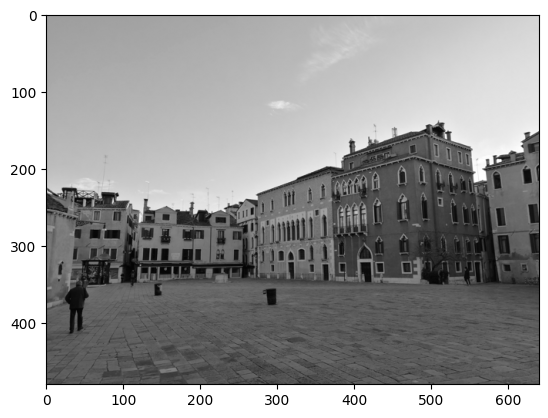

In [3]:
plt.imshow(image_array, cmap='gray')
plt.show()

# Creating testbench golden files

In [4]:
file = 'golden_input.txt'

with open(file, "w") as f:
    for i in range(height-2):
        for j in range(width):
            for k in range(3):
                f.writelines(f"{hex(image_array[i+k][j])[2:].upper()}\n")

with open(file, "r", encoding="utf-8") as f:
    content = f.read()

# Remove last character
content = content[:-1]

with open(file, "w", encoding="utf-8") as f:
    f.write(content)


In [5]:
# The same code will be implemented with C++ in HLS
SharpeningCoeffs = [
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
]

# Shift register
data_in_array = [
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]

def ImgSharpeningFilter(data_in_0, data_in_1, data_in_2):
    global data_in_array

    for i in range(3):
        for j in range(2, 0, -1):
            data_in_array[i][j] = data_in_array[i][j - 1]

    data_in_array[0][0] = int(data_in_0)
    data_in_array[1][0] = int(data_in_1)
    data_in_array[2][0] = int(data_in_2)

    add_res = 0
    for i in range(3):
        for j in range(3):
            add_res += data_in_array[i][j] * SharpeningCoeffs[i][j]

    # Clamp to 8-bit range
    if add_res < 0:
        add_res = 0
    elif add_res > 255:
        add_res = 255

    return add_res


In [46]:
# Remember to restart the shift register
input_file = "golden_input.txt"
output_file = "golden_output.txt"

with open(input_file, "r") as fin, open(output_file, "w") as fout:
    lines = fin.readlines()

    for i in range(0, len(lines), 3):
        if i + 2 >= len(lines):
            break

        b0 = int(lines[i].strip(), 16)
        b1 = int(lines[i + 1].strip(), 16)
        b2 = int(lines[i + 2].strip(), 16)

        result = ImgSharpeningFilter(b0, b1, b2)

        fout.write(f"{result:02X}\n")

Saved golden_output.png (478x640)


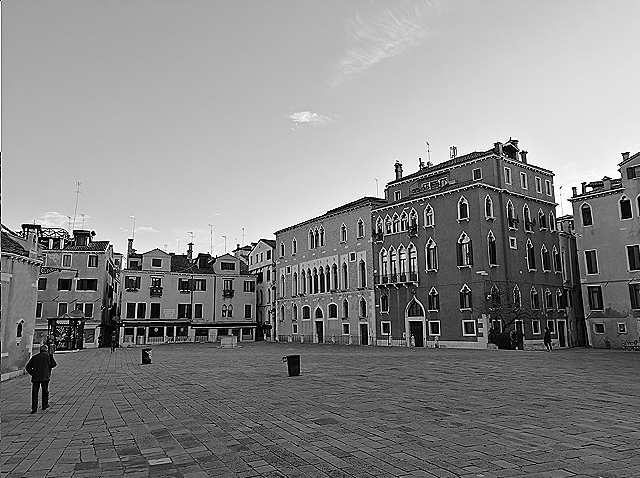

In [47]:
import numpy as np
from PIL import Image

H, W = 478, 640
in_file = "golden_output.txt"
out_png = "golden_output.png"

# Read hex bytes (one per line)
with open(in_file, "r") as f:
    vals = [int(line.strip(), 16) for line in f if line.strip()]

expected = H * W
if len(vals) < expected:
    raise ValueError(f"Not enough pixels: got {len(vals)}, expected {expected}")
if len(vals) > expected:
    vals = vals[:expected]  # ignore extras

# Reshape into image (row-major: first 640 lines = first row)
img = np.array(vals, dtype=np.uint8).reshape((H, W))

# Save / display
Image.fromarray(img, mode="L").save(out_png)
print(f"Saved {out_png} ({H}x{W})")

pil_img = Image.fromarray(img, mode="L")
display(pil_img)


# Running FPGA

### Send H and W

In [38]:
port = "/dev/ttyUSB1" 
baudrate = 921600

ser = serial.Serial(port, baudrate, timeout=1)
        
if ser.is_open:
    print(f"--- Connected to {port} at {baudrate} baud ---")

--- Connected to /dev/ttyUSB1 at 921600 baud ---


In [39]:
data = "{height:480,width:640}"

ser.write(data.encode('utf-8'))

22

In [2]:
PORT = "/dev/ttyUSB1"
BAUDRATE = 115200
TIMEOUT = 1  # seconds


INPUT_PATH  = Path("stream.txt")
OUTPUT_PATH = Path("output.txt")
LOG_EVERY = 1000

In [6]:
# Cell 2: helper to stream bytes from the ASCII-hex input file

def iter_input_bytes(path: Path):
    """
    Yields one integer (0..255) per non-empty line from a file
    containing ASCII hex bytes, e.g.:
        9E
        0a
        FF
    """
    with path.open("r", encoding="utf-8") as f:
        for lineno, line in enumerate(f, start=1):
            s = line.strip()
            if not s:
                continue
            try:
                val = int(s, 16)
            except ValueError as e:
                raise ValueError(f"Invalid hex on line {lineno}: {s!r}") from e
            if not (0 <= val <= 0xFF):
                raise ValueError(f"Out-of-range byte on line {lineno}: {s!r}")
            yield val


In [7]:
# Cell 3: main send/recv loop

def run_uart_file_transform(
    port: str,
    baud: int,
    input_path: Path,
    output_path: Path,
    log_every: int = 1000,
):
    # Open UART in fully blocking mode (no timeout)
    ser = serial.Serial(port=port, baudrate=baud, timeout=None, write_timeout=None)

    packets = 0
    bytes_iter = iter_input_bytes(input_path)

    # Open output file (overwrite). Use "a" if you want append instead.
    with output_path.open("w", encoding="utf-8") as out_f:
        try:
            buf = []
            for b in bytes_iter:
                buf.append(b)
                if len(buf) < 5:
                    continue

                # We have one 5-byte packet
                tx = bytes(buf)  # raw bytes to send
                buf.clear()

                # Send exactly 5 bytes
                ser.write(tx)
                # Optional: ensure it gets pushed out of OS buffer
                ser.flush()

                # Receive exactly 4 bytes (blocks until 4 are received)
                rx = ser.read(4)
                if len(rx) != 4:
                    # With timeout=None this shouldn't happen, but keep a sanity check
                    raise RuntimeError(f"Expected 4 bytes, got {len(rx)}")

                # Write response as 8 hex characters (uppercase), one line per packet
                out_f.write(rx.hex().upper() + "\n")

                packets += 1
                if packets % log_every == 0:
                    print(f"Packets processed: {packets}")

            # If input count isn't divisible by 5, ignore trailing bytes (or error if you prefer)
            if buf:
                print(f"Warning: {len(buf)} leftover input byte(s) ignored (input not multiple of 5).")

        finally:
            ser.close()

    print(f"Done. Total packets: {packets}. Output written to: {output_path}")

# Run it:
run_uart_file_transform(PORT, BAUDRATE, INPUT_PATH, OUTPUT_PATH, LOG_EVERY)


Packets processed: 1000
Packets processed: 2000
Packets processed: 3000
Packets processed: 4000
Packets processed: 5000
Packets processed: 6000
Packets processed: 7000
Packets processed: 8000
Packets processed: 9000
Packets processed: 10000
Packets processed: 11000
Packets processed: 12000
Packets processed: 13000
Packets processed: 14000
Packets processed: 15000
Packets processed: 16000
Packets processed: 17000
Packets processed: 18000
Packets processed: 19000
Packets processed: 20000
Packets processed: 21000
Packets processed: 22000
Packets processed: 23000
Packets processed: 24000
Packets processed: 25000
Packets processed: 26000
Packets processed: 27000
Packets processed: 28000
Packets processed: 29000
Packets processed: 30000
Packets processed: 31000
Packets processed: 32000
Packets processed: 33000
Packets processed: 34000
Packets processed: 35000
Packets processed: 36000
Packets processed: 37000
Packets processed: 38000
Packets processed: 39000
Packets processed: 40000
Packets p

Loaded image shape: (476, 640)
int32 range: 28911 to 1040073


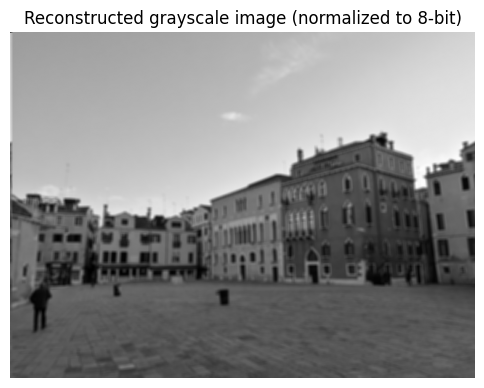

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# --- settings ---
path = "output.txt"
H, W = 476, 640
N = H * W

# --- load hex 32-bit values (one per line) ---
# Reads as strings, strips whitespace, converts from hex -> uint32
hex_str = np.loadtxt(path, dtype=str)
if hex_str.size != N:
    raise ValueError(f"Expected {N} pixels for a {H}x{W} image, got {hex_str.size} lines.")

vals_u32 = np.array([int(s, 16) for s in hex_str], dtype=np.uint32)

# If your 32-bit values are actually signed (two's complement), view as int32:
vals_i32 = vals_u32.view(np.int32)

# Reshape into image
img32 = vals_i32.reshape(H, W)

print("Loaded image shape:", img32.shape)
print("int32 range:", img32.min(), "to", img32.max())

# --- convert to displayable 8-bit grayscale ---
# Min-max normalize to 0..255 (good default when scale/offset is unknown)
img = img32.astype(np.float32)
mn, mx = float(img.min()), float(img.max())

if mx == mn:
    img8 = np.zeros((H, W), dtype=np.uint8)
else:
    img8 = np.clip((img - mn) * (255.0 / (mx - mn)), 0, 255).astype(np.uint8)

# --- show ---
plt.figure(figsize=(6, 6))
plt.imshow(img8, cmap="gray", vmin=0, vmax=255)
plt.title("Reconstructed grayscale image (normalized to 8-bit)")
plt.axis("off")
plt.show()

# --- optional: save ---
from PIL import Image
Image.fromarray(img8, mode="L").save("reconstructed.png")


In [8]:
import numpy as np
from PIL import Image

txt_path = "output.txt"

# 1) read hex (8 chars per pixel)
hex_str = open(txt_path, "r").read().strip()

# 2) convert to bytes, then to big-endian uint32
raw = bytes.fromhex(hex_str)
vals = np.frombuffer(raw, dtype=">u4")  # big-endian uint32

# 3) reshape to image (height=478, width=640)
h, w = 476, 640
u32_img = vals.reshape((h, w))

# 4) pixel transform: round(sqrt(value)) with clipping to 8-bit
img_u8 = np.clip(np.rint(np.sqrt(u32_img)), 0, 255).astype(np.uint8)

Image.fromarray(img_u8, mode="L").save("output.png")


In [ ]:
#HEX: 9C A0 9C A0 9C 9F 9A 9F 9A 99 9E 9D 9E 9D 9B 9B 9E 9B 9E 9F 9E 9D 9E 9D 9F

[108, 108, 111, 32, 87, 111, 114, 108, 100, 10, 13, 83, 117, 99, 99, 101, 115, 115, 102, 117]


In [ ]:
import numpy as np
from PIL import Image

txt_path = "flat_hex_output.txt"

# 1) read hex (8 chars per pixel)
hex_str = open(txt_path, "r").read().strip()

# 2) convert to bytes, then to big-endian uint32
raw = bytes.fromhex(hex_str)
vals = np.frombuffer(raw, dtype=">u4")  # big-endian uint32

# 3) reshape to image (height=478, width=640)
h, w = 512, 480
u32_img = vals.reshape((h, w))

# 4) pixel transform: round(sqrt(value)) with clipping to 8-bit
img_u8 = np.clip(np.rint(np.sqrt(u32_img)), 0, 255).astype(np.uint8)

Image.fromarray(img_u8, mode="L").save("wtf.png")




ValueError: cannot reshape array of size 61440 into shape (480,512)

# image recreation

### Original image

In [ ]:
with open('uart_result5.txt', 'r') as file:
    contents = file.read()
    char_count = len(contents)
    print(char_count/8)

print(640*478)

305920.0
305920


In [ ]:
from PIL import Image

HEX_FILE = "hex_original.txt"     # your hex-per-line file
OUT_IMAGE = "original.png"

WIDTH = 640
HEIGHT = 480
EXPECTED = WIDTH * HEIGHT

# Read and parse hex values
pixels = []
with open(HEX_FILE, "r", encoding="ascii") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue  # skip empty lines
        # Each line is a hex byte like "00".."FF"
        pixels.append(int(s, 16))

# Validate size
if len(pixels) != EXPECTED:
    raise ValueError(f"Expected {EXPECTED} pixels, but got {len(pixels)}")

# Create grayscale image ('L' = 8-bit pixels)
img = Image.frombytes("L", (WIDTH, HEIGHT), bytes(pixels))

# Save
img.save(OUT_IMAGE)
print(f"Saved {OUT_IMAGE} ({WIDTH}x{HEIGHT})")


Saved original.png (640x480)


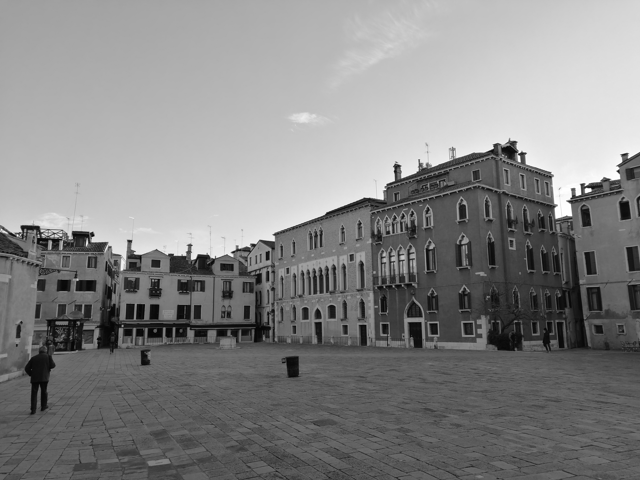

In [ ]:
from IPython.display import Image, display
venice_path = "/home/szymon/Desktop/CORA_Z7/projekt/serial_monitor/serial_monitor/original.png"
# Replace 'my_image.png' with your actual file path
display(Image(filename=venice_path, width=500, height=300))

### Filtered image

In [ ]:
import numpy as np
from PIL import Image

txt_path = "uart_result5.txt"

# 1) read hex (8 chars per pixel)
hex_str = open(txt_path, "r").read().strip()

# 2) convert to bytes, then to big-endian uint32
raw = bytes.fromhex(hex_str)
vals = np.frombuffer(raw, dtype=">u4")  # big-endian uint32

# 3) reshape to image (height=478, width=640)
h, w = 478, 640
u32_img = vals.reshape((h, w))

# 4) pixel transform: round(sqrt(value)) with clipping to 8-bit
img_u8 = np.clip(np.rint(np.sqrt(u32_img)), 0, 255).astype(np.uint8)

Image.fromarray(img_u8, mode="L").save("venice_filtred_5_reconstructed.png")




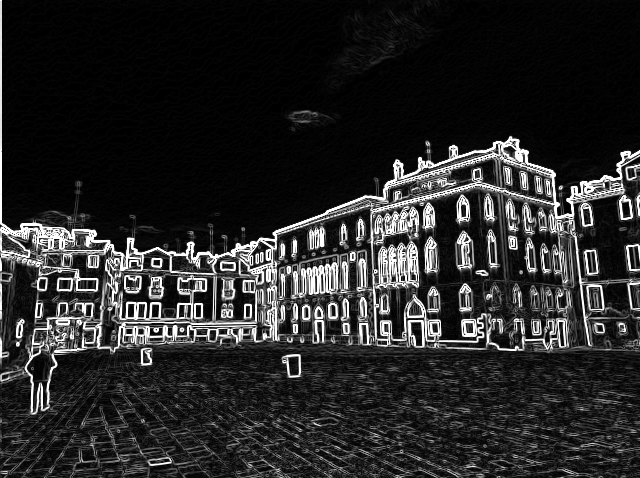

In [ ]:
from IPython.display import Image, display
venice_path = "/home/szymon/Desktop/CORA_Z7/projekt/serial_monitor/serial_monitor/venice_filtred_5_reconstructed.png"
# Replace 'my_image.png' with your actual file path
display(Image(filename=venice_path, width=500, height=300))

In [ ]:
import os

file_path = 'uart_result5.txt'

with open(file_path, 'rb') as f:
    # Move the cursor to 100 bytes before the end of the file
    try:
        f.seek(-100, os.SEEK_END)
        content = f.read().decode('utf-8')
    except OSError:
        # If the file is smaller than 100 characters, seek to the start
        f.seek(0)
        content = f.read().decode('utf-8')

print(content)

0122000000520000024400000184000000E800000208000003DA000002A4000002A20000072400000B080000069A00000484


In [ ]:
with open('test.txt', 'r') as f:
    # Read lines, strip the newline from each, and join them together
    single_line = "".join(line.strip() for line in f)

with open('test.txt', 'w') as f:
    f.write(single_line)